## Importing the libraries

In [1]:
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn

from matplotlib import rc

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

## Functions

#### Activation function

In [2]:
def activation(z, act):
    """
    Activation function
    
    activation (z, act)    
    
    return (func) 
    """

    # Sigmoid
    if act == 'sig':
        func = 1/(1+np.exp(-z))

    # Hiperbolic tangent
    elif act == 'tanh':
        func = np.tanh(z)
    
    # Rectified Linear Unit (ReLU)
    elif act == 'Relu':
        func = np.maximum(0,z)
    
    else:
        print('Error! Activation function is not identied.')

    return func

#### Derivative of the activation functions

In [3]:
def derivates(z, act, X):
    """
    Derivative function
    
    derivates(a, act):

    return(der)
    """
    # Sigmoid
    if act == 'sig':
        a = activation(z, act)
        a = np.vstack((a,np.ones(len(X))))
        der = a*(1-a)


    # Hiperbolic Tangent
    elif act == 'tanh':
        a = activation(z, act)
        a = np.vstack((a,np.ones(len(X))))
        der = (1-a**2)

    
    # ReLU
    elif act == 'Relu':
        z[z<=0] = 0
        z[z>0] = 1

        der = np.vstack((z,np.ones(len(X))))

    else:
        print('Error! Activation function is not identied.')

    return der  

#### Cost function - Binary Cross-Entropy

In [4]:
def BCE(X,W,y,Neurons, act):
    """
    
    Cost function
    
    BCE(X,W,y,Neurons)
    
    return -np.sum(y*np.log(h) + (1-y)*np.log(1-h))/len(y)
    
    """
    
    # Forward propagation of the neural network
    a_mat = forward_prop(X, W, Neurons, act)
    h = a_mat[-1]
    
    return -np.sum(y*np.log(h) + (1-y)*np.log(1-h))/len(y)

#### Function for the numerical calculation of the gradient

In [5]:
def Grad(W, X, y, Neurons):
    
    """
    
    Numerical gradient
    
    rad(W, X, y, Neurons)
    
    return Grad_aprox
    
    """
    
    # Increment of the weights and biases
    Epsilon = 10**-15
    
    # Copying the size of the weights and biases matrix
    Grad_aprox = copy.deepcopy(W)
    
    #Iterating over each layer, input and output node
    for i in range(len(W)):
        for j in range(np.shape(W[i])[0]):
            for k in range(np.shape(W[i])[1]):
                
                # Copying two lists for the values above and below
                W_plus = copy.deepcopy(W)
                W_minus = copy.deepcopy(W)
                
                # Adding the increments
                W_plus[i][j][k] = W_plus[i][j][k] + Epsilon
                W_minus[i][j][k] = W_minus[i][j][k] - Epsilon
                
                # Calculation of the gradiente
                Grad_aprox[i][j][k] = (BCE(X, W_plus, y, Neurons) - BCE(X, W_minus, y, Neurons))/(2*Epsilon)
            
    return Grad_aprox

#### Forward Propagation

In [6]:
def forward_prop(X, W, Neurons, act):
    """
    
    Forward Propagation
    
    forward_prop(X, W)
    
    return a_mat
    
    """
    
    # a^(1) = X + 1
    a = np.vstack((np.array(X).T, np.ones(len(np.array(X)))))
    a_vec = copy.deepcopy(a)
    
    #Iterating over each layer
    for c,v in enumerate(W):

        a = a_vec[-np.shape(v)[1]:]

        # z^(c) = theta^(c-1)*a^(c-1)
        z = np.dot(v,a)

        if c != len(W)-1:            
            
            # Applying the activation function
            a = activation(z, act)
            add_one = np.ones(np.shape(a_vec[-np.shape(v)[1]:])[1])

            # a^(c) = a^(c) + 1        
            a = np.vstack((a,add_one))
        
        else:
            # a^(c) = sigmoid(z^(c))
            a = activation(z, 'sig')
        
        a_vec = np.vstack((a_vec,a))
    
    a_mat = []
    for i in range(len(Neurons)):
        a_mat.append(a_vec[sum(Neurons[:i])+i:sum(Neurons[:i+1])+i+1])
    
    return a_mat

#### Backward Propagation

In [7]:
def backward_prop(a_mat, sigma, Delta, Neurons, y, W, act, X):
    """
    
    Backward Propagation
    
    backward_prop(a_mat, sigma, Delta, Neurons, y, W)
    
    return Delta
    
    """   
    
    # sigma^(L) = a^(L) - y
    sigma[len(Neurons)-2] = (a_mat[-1] - y)
    
    # sigma^(L-1) = W^(L-1)^T*sigma^(L)*(a^(L-1))*(1- a^(L-1))
    i = len(Neurons)-3
    sigma[i] = np.dot(W[i+1].T,sigma[i+1])*derivates(np.dot(W[i],a_mat[i]), act, X)

    # Iterating until sigma^(2)
    for i in range(len(W)-3,-1,-1):

        # sigma^(l-1) = W^(l-1)^T*sigma^(l)*(a^(l-1))*(1- a^(l-1))
        sigma[i] = np.dot(W[i+1].T,sigma[i+1][:-1])*derivates(np.dot(W[i],a_mat[i]), act, X)
    
    # Iterating until L-1
    for i in range(len(sigma)-1):
        
        # Delta^(l) = Delta^(l) + a^(l)*sigma^(l+1) 
        Delta[i] = np.dot(a_mat[i],sigma[i].T).T[:-1]/len(y)
    
    return Delta

#### Gradient Descent

In [8]:
def Neural_Network(alpha, it, W, X, sigma, Delta, y, Neurons, X_t, y_t, act, Silent = True, Grad_aprox = False):
    """
    
    Gradient Descent
        
    Neural_Network(alpha, it, W, X, sigma, Delta, y, Neurons):
    
    print(BCE(X_train,W,y_train.values))
    
    return(W)
    """
    
    Perf = []   
    for iter in range(it):
        
        # Forward Propagation
        a_mat  = forward_prop(X, W, Neurons, act)
        
        # Backward Propagation
        Del = backward_prop(a_mat, sigma, Delta, Neurons, y, W, act, X)
        
        # Updating the weights
        W = list(W - alpha*np.array(Del))
        
        # Printing the cost fuunction and accuracy
        acc      = np.sum(np.round(forward_prop(X, W, Neurons, act)[-1]) == y)/len(y)*100
        acc_test = np.sum(np.round(forward_prop(X_t, W, Neurons, act)[-1]) == y_t)/len(y_t)*100
        
        Loss      = BCE(X  , W, y  , Neurons, act)
        Loss_test = BCE(X_t, W, y_t, Neurons, act)
        
        Perf.append([acc, acc_test, Loss, Loss_test])
        
        if Silent == False:
            print('The accuracy in the iteraction is '     + str(iter) + ' é de ' +str(acc))
            print('The cost function in the interaction is ' + str(iter) + ' é de ' +str(Loss))
        
        # Comparisson between the analytical and numerical gradient solution
        if Grad_aprox == True:
            if iter % (it/5) == 0:
                error = np.abs(np.array(Del) - np.array(Grad(W, X, y, Neurons)))
                error_deriv = [error[i].mean() for i in range(len(Neurons)-1)]
                print('Gradient error: ' +str(error_deriv))
    
    accu = np.round(np.sum(np.round(forward_prop(X, W, Neurons, act)[-1]) == y)/len(y)*100,2)
    print('The accuracy in the training set is  ' + str(accu) + '%')
    
    cm = confusion_matrix(list(np.round(forward_prop(X_t, W, Neurons, Actv)[-1])[0]),list(y_t))
    
    return(W , Perf, cm)

## Plotting functions

In [9]:
def Plot_Acc(Perf, Actv, It, alpha):
    """
    Accuracy Plot
    
    
    Plot_Acc(Perf, Actv, It)
    """
    
    plt.figure(figsize = (6, 6/1.618))
    plt.plot(np.array(Perf).T[0],':', label = 'Training')
    plt.plot(np.array(Perf).T[1],'--', label = 'Test')

    plt.grid(linestyle = ':')
    plt.legend()
    
    plt.xlabel('Epoch [-]')
    plt.ylabel('Accuracy [\%]')
    
    plt.savefig('Plots/Accuracy_'+str(Actv)+'_'+str(It)+'_' +str(alpha)+'_' + str(Neurons)+'.png', format = 'png',dpi = 600, bbox_inches = 'tight')

In [10]:
def Plot_Loss(Perf, Actv, It, alpha):
    """
    Plot Loss function
    
    
    Plot_Loss(Perf, Actv, It)
    """
    
    plt.figure(figsize = (6, 6/1.618))
    plt.plot(np.array(Perf).T[2],':', label = 'Train')
    plt.plot(np.array(Perf).T[3],'--', label = 'Test')
    
    plt.grid(linestyle = ':')
    plt.legend()
    
    plt.xlabel('Epoch [-]')
    plt.ylabel('Cost function [-]')
    
    plt.savefig('Plots/Cost_'+str(Actv)+'_'+str(It)+'_' +str(alpha)+'_'+ str(Neurons) +'.png', format = 'png',dpi = 600, bbox_inches = 'tight')

In [11]:
def Plot_CM(cm):
    
    classes = ["0", "1"]

    df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
    plt.figure(figsize = (6,6/1.618))
    cfm_plot = sn.heatmap(df_cfm, annot=True)
    plt.ylabel('Ground truth')
    plt.xlabel('Prediction')
    cfm_plot.figure.savefig('Plots/CM_'+str(Actv)+'_'+str(It)+'_' +str(alpha)+'_'+ str(Neurons)+'.png', format = 'png',dpi = 600, bbox_inches = 'tight')

In [12]:
def Plot_Front(W_, Neurons, Actv, It,alpha):
    """
    Decision frontier plot
    
    
    Plot_Loss(Perf, Actv, It)
    """
    x_min, x_max = -1, 1.25
    xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100),np.linspace(x_min, x_max, 100))
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = np.round(forward_prop(x_in, W_, Neurons, Actv)[-1])
    y_pred = pd.DataFrame(y_pred.reshape(xx.shape))

    df=pd.read_csv("data/classification2.txt", header=None)

    X=df.iloc[:,:-1].values
    y=df.iloc[:,-1].values


    pos , neg = (y==1).reshape(len(X),1) , (y==0).reshape(len(X),1)
    
    plt.figure(figsize = (6, 6/1.618))
    plt.scatter(X[pos[:,0],0],X[pos[:,0],1],c="b",marker="+")
    plt.scatter(X[neg[:,0],0],X[neg[:,0],1],c="r",marker="o",s=10)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdBu, alpha=0.5)

    plt.xlabel("x1 [-]")
    plt.ylabel("x2 [-]")
    plt.legend(["1","0"],loc=0)
    plt.savefig('Plots/Frontier_'+str(Actv)+'_'+str(It)+'_' +str(alpha)+'_'+ str(Neurons)+'.png', format = 'png',dpi = 600, bbox_inches = 'tight')

### Inputs 

In [13]:
Data = pd.read_csv('Data/classification2.txt', names = ['X1', 'X2', 'y'])

### Train test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split( Data[['X1','X2']], 
                                                     Data['y'], 
                                                     test_size=0.2, 
                                                     random_state=42,
                                                     stratify = Data['y'])

## Neural Network

In [15]:
# Architecture of the Neural Network
Neurons = [X_train.shape[1], 100, 10, 1]

# Learning rate
alpha = 1

# Number of epochs
It = 10000

# Activation function
Actv = 'tanh'

# Weights
W = []

# Derivatives
Delta = []

#Errors
sigma = []


for i in range(len(Neurons)-1):

    # Xavier Initialization
    W.append(np.sqrt(6)/(Neurons[i+1] + Neurons[i])*np.random.randn(Neurons[i+1],Neurons[i]+1))
    
    Delta.append(np.zeros([Neurons[i+1],Neurons[i]+1]))
    sigma.append(np.zeros([1,1]))


# Neural Network
W_, Perf, cm = Neural_Network(alpha, It, W, X_train, sigma, Delta, y_train.values, Neurons, 
                          X_test, y_test.values, Actv,Silent = True, Grad_aprox = False)

The accuracy in the training set is  94.68%


#### Accuracy on the test set

The accuracy of the model in the test set is 70.83%


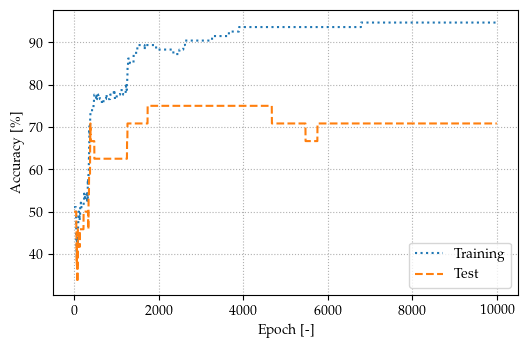

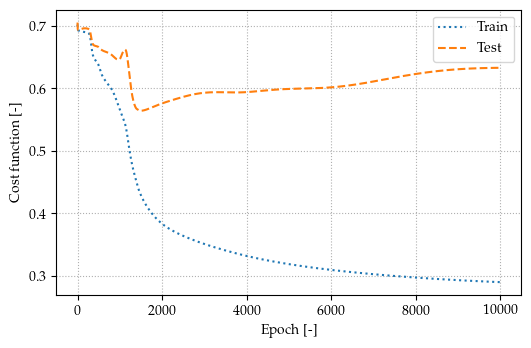

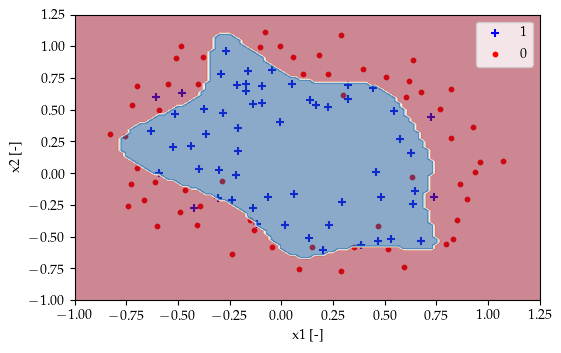

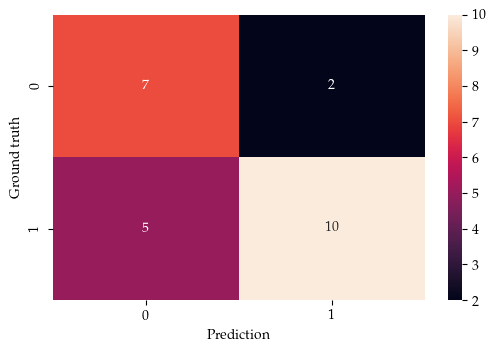

In [16]:
acc_test = np.round((np.round(forward_prop(X_test, W_, Neurons, Actv)[-1]) == y_test.values).sum()/len(y_test)*100,2)
print('The accuracy of the model in the test set is ' + str(acc_test) + '%')

Plot_Acc(Perf, Actv, It, alpha)
Plot_Loss(Perf, Actv, It, alpha)
Plot_Front(W_, Neurons, Actv, It, alpha)
Plot_CM(cm)

## Assesment of the learning rate

#### Lower learning rate

In [17]:
# Architecture of the Neural Network
Neurons = [X_train.shape[1], 100, 10, 1]

# Learning rate
alpha = 0.1

# Number of epochs
It = 10000

# Activation function
Actv = 'tanh'

# Weights
W = []

# Derivatives
Delta = []

#Errors
sigma = []


for i in range(len(Neurons)-1):

    # Xavier Initialization
    W.append(np.sqrt(6)/(Neurons[i+1] + Neurons[i])*np.random.randn(Neurons[i+1],Neurons[i]+1))
    
    Delta.append(np.zeros([Neurons[i+1],Neurons[i]+1]))
    sigma.append(np.zeros([1,1]))


# Neural Network
W_, Perf, cm = Neural_Network(alpha, It, W, X_train, sigma, Delta, y_train.values, Neurons, 
                          X_test, y_test.values, Actv,Silent = True, Grad_aprox = False)

The accuracy in the training set is  50.0%


#### Acuracy on the test set

The accuracy of the model in the test set is 41.67%


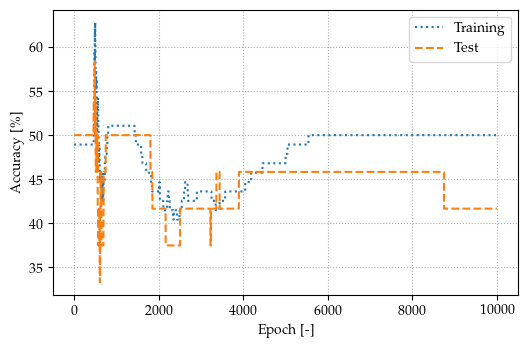

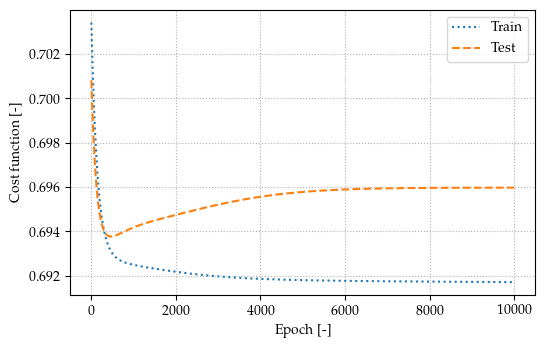

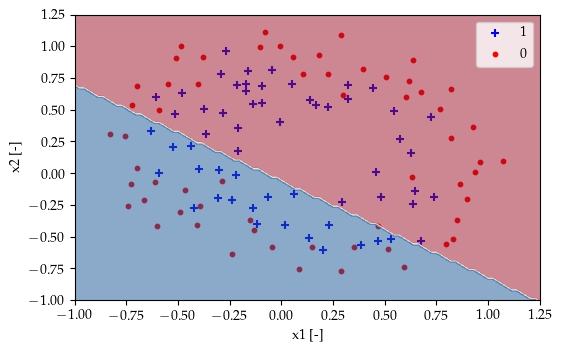

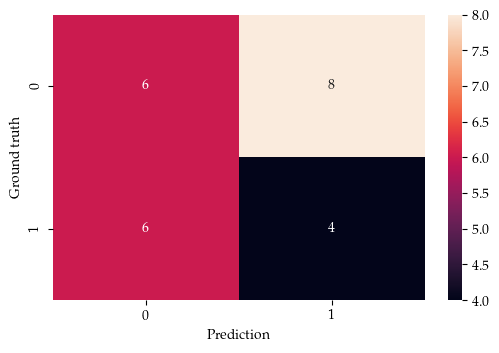

In [18]:
acc_test = np.round((np.round(forward_prop(X_test, W_, Neurons, Actv)[-1]) == y_test.values).sum()/len(y_test)*100,2)
print('The accuracy of the model in the test set is ' + str(acc_test) + '%')

Plot_Acc(Perf, Actv, It, alpha)
Plot_Loss(Perf, Actv, It, alpha)
Plot_Front(W_, Neurons, Actv, It, alpha)
Plot_CM(cm)

#### Higher learning rate

In [19]:
# Architecture of the Neural Network
Neurons = [X_train.shape[1], 100, 10, 1]

# Learning rate
alpha = 10

# Number of epochs
It = 10000

# Activation function
Actv = 'tanh'

# Weights
W = []

# Derivatives
Delta = []

#Errors
sigma = []


for i in range(len(Neurons)-1):

    # Xavier Initialization
    W.append(np.sqrt(6)/(Neurons[i+1] + Neurons[i])*np.random.randn(Neurons[i+1],Neurons[i]+1))
    
    Delta.append(np.zeros([Neurons[i+1],Neurons[i]+1]))
    sigma.append(np.zeros([1,1]))


# Neural Network
W_, Perf, cm = Neural_Network(alpha, It, W, X_train, sigma, Delta, y_train.values, Neurons, 
                          X_test, y_test.values, Actv,Silent = True, Grad_aprox = False)

The accuracy in the training set is  97.87%


#### Accuracy on the test set

The accuracy on the test set is 66.67%


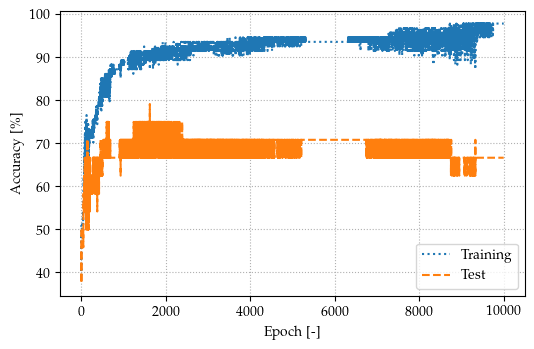

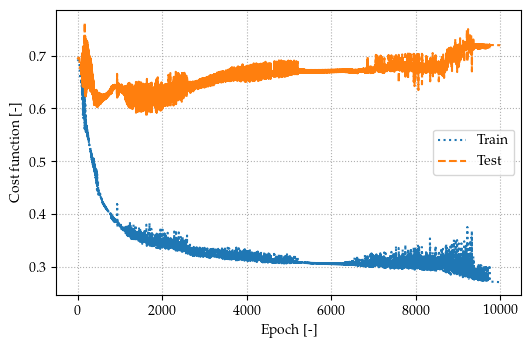

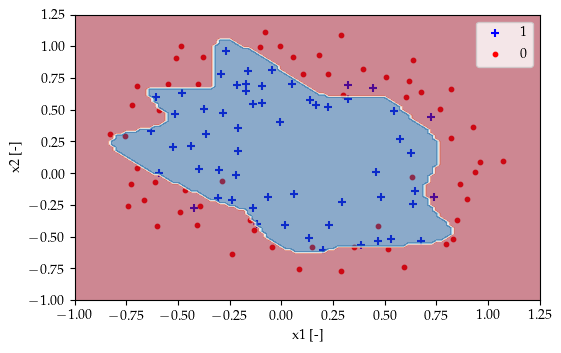

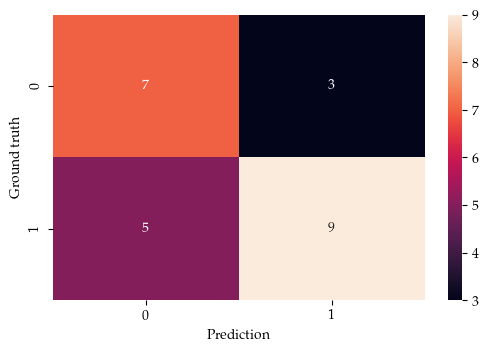

In [20]:
acc_test = np.round((np.round(forward_prop(X_test, W_, Neurons, Actv)[-1]) == y_test.values).sum()/len(y_test)*100,2)
print('The accuracy on the test set is ' + str(acc_test) + '%')

Plot_Acc(Perf, Actv, It, alpha)
Plot_Loss(Perf, Actv, It, alpha)
Plot_Front(W_, Neurons, Actv, It, alpha)
Plot_CM(cm)

## Assesment over the neural network architecture

### Number of layers

#### 1 Layer

In [21]:
# Architecture of the Neural Network
Neurons = [X_train.shape[1], 100, 1]

# Learning rate
alpha = 1

# Number of epochs
It = 10000

# Activation function
Actv = 'tanh'

# Weights
W = []

# Derivatives
Delta = []

#Errors
sigma = []


for i in range(len(Neurons)-1):

    # Xavier Initialization
    W.append(np.sqrt(6)/(Neurons[i+1] + Neurons[i])*np.random.randn(Neurons[i+1],Neurons[i]+1))
    
    Delta.append(np.zeros([Neurons[i+1],Neurons[i]+1]))
    sigma.append(np.zeros([1,1]))


# Neural Network
W_, Perf, cm = Neural_Network(alpha, It, W, X_train, sigma, Delta, y_train.values, Neurons, 
                          X_test, y_test.values, Actv,Silent = True, Grad_aprox = False)

The accuracy in the training set is  59.57%


#### Accuracy on the test set

The accuracy on the test set is 58.33%


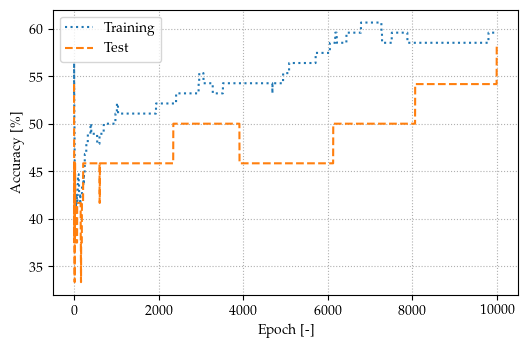

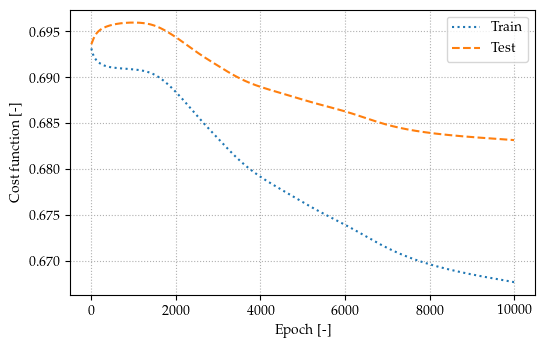

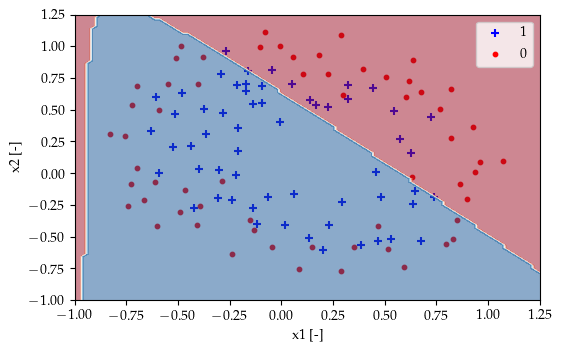

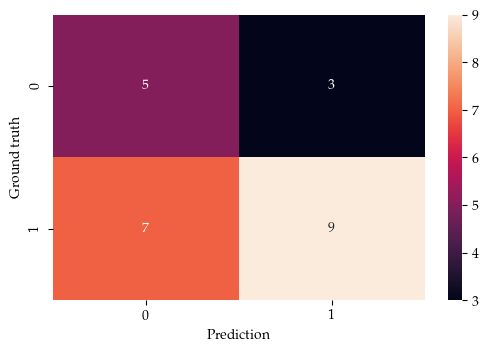

In [22]:
acc_test = np.round((np.round(forward_prop(X_test, W_, Neurons, Actv)[-1]) == y_test.values).sum()/len(y_test)*100,2)
print('The accuracy on the test set is ' + str(acc_test) + '%')

Plot_Acc(Perf, Actv, It, alpha)
Plot_Loss(Perf, Actv, It, alpha)
Plot_Front(W_, Neurons, Actv, It, alpha)
Plot_CM(cm)

#### 3 Layers

In [23]:
# Architecture of the Neural Network
Neurons = [X_train.shape[1], 100, 10, 5, 1]

# Learning rate
alpha = 1

# Number of epochs
It = 10000

# Activation function
Actv = 'tanh'

# Weights
W = []

# Derivatives
Delta = []

#Errors
sigma = []


for i in range(len(Neurons)-1):

    # Xavier Initialization
    W.append(np.sqrt(6)/(Neurons[i+1] + Neurons[i])*np.random.randn(Neurons[i+1],Neurons[i]+1))
    
    Delta.append(np.zeros([Neurons[i+1],Neurons[i]+1]))
    sigma.append(np.zeros([1,1]))


# Neural Network
W_, Perf, cm = Neural_Network(alpha, It, W, X_train, sigma, Delta, y_train.values, Neurons, 
                          X_test, y_test.values, Actv,Silent = True, Grad_aprox = False)

The accuracy in the training set is  84.04%


#### Accuracy on the test set

The accuracy on the test set is 62.5%


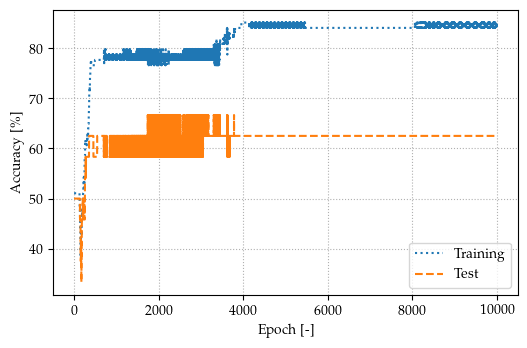

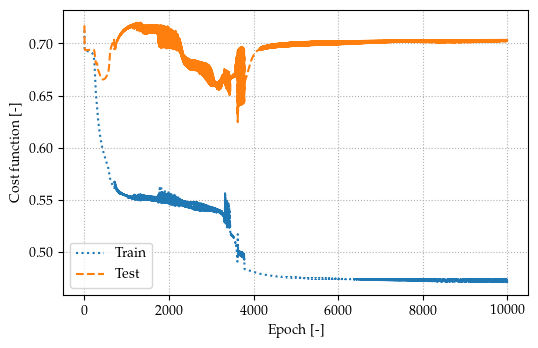

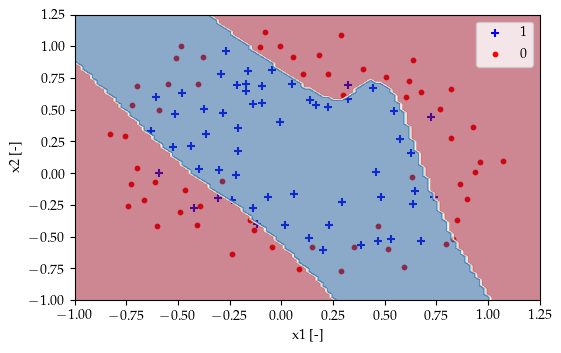

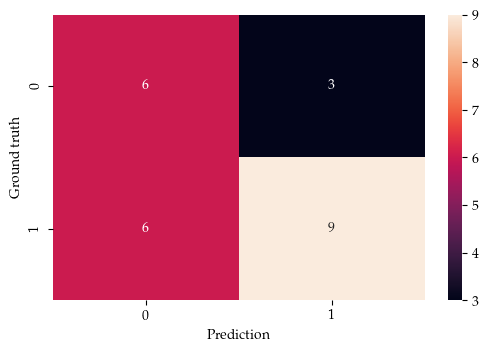

In [24]:
acc_test = np.round((np.round(forward_prop(X_test, W_, Neurons, Actv)[-1]) == y_test.values).sum()/len(y_test)*100,2)
print('The accuracy on the test set is ' + str(acc_test) + '%')

Plot_Acc(Perf, Actv, It, alpha)
Plot_Loss(Perf, Actv, It, alpha)
Plot_Front(W_, Neurons, Actv, It, alpha)
Plot_CM(cm)

### 3 Layers - Version 2

In [ ]:
# Architecture of the Neural Network
Neurons = [X_train.shape[1], 1000, 100, 10, 1]

# Learning rate
alpha = 1

# Number of epochs
It = 10000

# Activation function
Actv = 'tanh'

# Weights
W = []

# Derivatives
Delta = []

#Errors
sigma = []


for i in range(len(Neurons)-1):

    # Xavier Initialization
    W.append(np.sqrt(6)/(Neurons[i+1] + Neurons[i])*np.random.randn(Neurons[i+1],Neurons[i]+1))
    
    Delta.append(np.zeros([Neurons[i+1],Neurons[i]+1]))
    sigma.append(np.zeros([1,1]))


# Neural Network
W_, Perf, cm = Neural_Network(alpha, It, W, X_train, sigma, Delta, y_train.values, Neurons, 
                          X_test, y_test.values, Actv,Silent = True, Grad_aprox = False)

#### Accuracy on the test set

In [ ]:
acc_test = np.round((np.round(forward_prop(X_test, W_, Neurons, Actv)[-1]) == y_test.values).sum()/len(y_test)*100,2)
print('The accuracy on the test set is ' + str(acc_test) + '%')

Plot_Acc(Perf, Actv, It, alpha)
Plot_Loss(Perf, Actv, It, alpha)
Plot_Front(W_, Neurons, Actv, It, alpha)
Plot_CM(cm)

## Activation function

### Sigmoid

In [ ]:
# Architecture of the Neural Network
Neurons = [X_train.shape[1], 100, 10, 1]

# Learning rate
alpha = 1

# Number of epochs
It = 10000

# Activation function
Actv = 'sig'

# Weights
W = []

# Derivatives
Delta = []

#Errors
sigma = []


for i in range(len(Neurons)-1):

    # Xavier Initialization
    W.append(np.sqrt(6)/(Neurons[i+1] + Neurons[i])*np.random.randn(Neurons[i+1],Neurons[i]+1))
    
    Delta.append(np.zeros([Neurons[i+1],Neurons[i]+1]))
    sigma.append(np.zeros([1,1]))


# Neural Network
W_, Perf, cm = Neural_Network(alpha, It, W, X_train, sigma, Delta, y_train.values, Neurons, 
                          X_test, y_test.values, Actv,Silent = True, Grad_aprox = False)

#### Accuracy on the test set

In [ ]:
acc_test = np.round((np.round(forward_prop(X_test, W_, Neurons, Actv)[-1]) == y_test.values).sum()/len(y_test)*100,2)
print('The accuracy on the test set is ' + str(acc_test) + '%')

Plot_Acc(Perf, Actv, It,alpha)
Plot_Loss(Perf, Actv, It, alpha)
Plot_Front(W_, Neurons, Actv, It, alpha)
Plot_CM(cm)

### ReLU

In [ ]:
# Architecture of the Neural Network
Neurons = [X_train.shape[1], 100, 10, 1]

# Learning rate
alpha = 1

# Number of epochs
It = 10000

# Activation function
Actv = 'Relu'

# Weights
W = []

# Derivatives
Delta = []

#Errors
sigma = []


for i in range(len(Neurons)-1):

    # Xavier Initialization
    W.append(np.sqrt(6)/(Neurons[i+1] + Neurons[i])*np.random.randn(Neurons[i+1],Neurons[i]+1))
    
    Delta.append(np.zeros([Neurons[i+1],Neurons[i]+1]))
    sigma.append(np.zeros([1,1]))


# Neural Network
W_, Perf, cm = Neural_Network(alpha, It, W, X_train, sigma, Delta, y_train.values, Neurons, 
                          X_test, y_test.values, Actv,Silent = True, Grad_aprox = False)

#### Accuracy on the test set

In [ ]:
acc_test = np.round((np.round(forward_prop(X_test, W_, Neurons, Actv)[-1]) == y_test.values).sum()/len(y_test)*100,2)
print('The accuarcy on the test set is' + str(acc_test) + '%')

Plot_Acc(Perf, Actv, It, alpha)
Plot_Loss(Perf, Actv, It, alpha)
Plot_Front(W_, Neurons, Actv, It, alpha)
Plot_CM(cm)